In [2]:
import re
import nltk

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder

import numpy as np

from pytorchtools_st import EarlyStopping

import matplotlib.pyplot as plt

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [14]:
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.snowball import SnowballStemmer

In [5]:
text = 'Select your preferences and run the install command. Stable represents the most currently tested and supported version of PyTorch. Note that LibTorch is only available for C++'

In [4]:
def preprocess_text(text):
  text = text.lower()
  text = re.sub(r"[^a-zA-Z.,!?]", " ", text)
  return text

In [7]:
preprocess_text(text)

'select your preferences and run the install command. stable represents the most currently tested and supported version of pytorch. note that libtorch is only available for c  '

In [8]:
word_tokenize(text)

['Select',
 'your',
 'preferences',
 'and',
 'run',
 'the',
 'install',
 'command',
 '.',
 'Stable',
 'represents',
 'the',
 'most',
 'currently',
 'tested',
 'and',
 'supported',
 'version',
 'of',
 'PyTorch',
 '.',
 'Note',
 'that',
 'LibTorch',
 'is',
 'only',
 'available',
 'for',
 'C++']

In [9]:
text = preprocess_text(text)
vocab = list(set(word_tokenize(text))) # Уникальные слова
sent_t = torch.zeros(len(vocab)) 
sent = sent_tokenize(text)[0]

for word in word_tokenize(sent):
  sent_t[vocab.index(word)] = 1

sent_t

tensor([0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 1., 0., 0., 1., 0., 0., 1.])

## Классификация фамилий по национальности

Датасет: https://disk.yandex.ru/d/owHew8hzPc7X9Q?w=1

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [106]:
df = pd.read_csv('/content/drive/MyDrive/datasets/surnames.csv')
df.shape, display(df.head())

,surname,nationality
0,Woodford,English
1,Coté,French
2,Kore,English
3,Koury,Arabic
4,Lebzak,Russian


((10980, 2), None)

In [107]:
enc = LabelEncoder()
df['nationality_label'] = enc.fit_transform(df['nationality'])
df.head()

,surname,nationality,nationality_label
0,Woodford,English,4
1,Coté,French,5
2,Kore,English,4
3,Koury,Arabic,0
4,Lebzak,Russian,14


In [108]:
X_train, X_test, y_train, y_test = train_test_split(df['surname'], df['nationality_label'], stratify = np.array(df['nationality_label']), 
                                                    test_size = 0.1)

In [109]:
class Vocab:
  def __init__(self, data):
    tokens = set()
    for surname in data:
      tokens.update(surname)

    self.idx_to_token = {idx: token for idx, token in enumerate(tokens)} # Индекс токен: буква
    self.token_to_idx = {token: idx for idx, token in self.idx_to_token.items()} # обратный первому
    self.vocab_len = len(self.idx_to_token)

In [110]:
vocab = Vocab(df['surname'])
vocab.vocab_len

84

In [111]:
class SurnamesDataset(Dataset):
  def __init__(self, X, y, vocab: Vocab):
    self.X = X
    self.y = y
    self.vocab = vocab

  def vectorize(self, surname):
    '''Генерирует представление отзыва review в виде bag of words (см. 1.2.1)'''
    
    surname_t = torch.zeros(self.vocab.vocab_len)
    
    for char in surname:
      surname_t[self.vocab.token_to_idx[char]] = 1

    return surname_t

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.vectorize(self.X[idx]), self.y[idx]

In [112]:
dataset = SurnamesDataset(list(X_train), list(y_train), vocab)
dataset[0]

(tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), 4)

In [178]:
class ModelSurnameNat(nn.Module):
  def __init__(self, input_size, hidden_size, n_classes):
    super().__init__()
    self.layer1 = nn.Sequential(nn.Linear(input_size, hidden_size),
                                nn.ReLU(),
                                nn.Dropout())
    self.layer2 = nn.Sequential(nn.Linear(hidden_size, int(hidden_size/2)),
                                nn.ReLU())
    self.layer3 = nn.Sequential(nn.Linear(int(hidden_size/2), int(hidden_size/4)),
                                nn.ReLU())
    self.layer4 = nn.Linear(int(hidden_size/4), n_classes)

  def forward(self, X):
    out = self.layer1(X)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    return out

In [179]:
dataset_train = SurnamesDataset(list(X_train), list(y_train), vocab)

train_size = int(np.floor(0.8 * len(dataset_train)))
val_size = len(dataset_train) - train_size

train_dataset, test_dataset = random_split(dataset_train, [train_size, val_size])

train_data = DataLoader(train_dataset, batch_size = 32, shuffle = True)
validation = DataLoader(test_dataset, batch_size = 32, shuffle = True)

input_size = dataset_train[0][0].shape[0]
hidden_size = 512
n_classes = df['nationality_label'].nunique()

model = ModelSurnameNat(input_size, hidden_size, n_classes)
criteriation = nn.CrossEntropyLoss()
optimizare = optim.Adam(model.parameters(), lr = 0.001)

early_stop = EarlyStopping(patience = 3, verbose = False, delta = 0.0)

n_epochs = 500

history_loss = list()
history_loss_val = list()
history_epochs = list()

for epoch in range(1, n_epochs + 1):
  loss_train = 0
  loss_val = 0

  model.train()
  for name, label in train_data:
    out = model(name)

    loss = criteriation(out, label)
    loss_train += loss

    loss.backward()
    optimizare.step()
    optimizare.zero_grad()

  model.eval()
  with torch.no_grad():
    for X, y in validation:
      out = model(X)
      loss = criteriation(out, y)
      loss_val += loss

  history_loss.append(loss_val/len(train_data))
  history_loss_val.append(loss_val/len(validation))
  history_epochs.append(epoch)

  if epoch % 2 == 0:
    print(f'Epoch: [{epoch}/{n_epochs}]: Loss_Train = {history_loss[-1]}; Loss_Validation = {history_loss_val[-1]}')

  early_stop(history_loss_val[-1], model)
  
  if early_stop.early_stop:
      print(f"Early stopping on epoch: [{epoch}/{n_epochs}]")
      break

Epoch: [2/500]: Loss_Train = 0.3365686535835266; Loss_Validation = 1.3462746143341064
Epoch: [4/500]: Loss_Train = 0.29770296812057495; Loss_Validation = 1.1908118724822998
Epoch: [6/500]: Loss_Train = 0.2803642153739929; Loss_Validation = 1.1214568614959717
EarlyStopping counter: 1 out of 3
Epoch: [8/500]: Loss_Train = 0.26904991269111633; Loss_Validation = 1.0761996507644653
Epoch: [10/500]: Loss_Train = 0.26473185420036316; Loss_Validation = 1.0589274168014526
EarlyStopping counter: 1 out of 3
Epoch: [12/500]: Loss_Train = 0.26422327756881714; Loss_Validation = 1.0568931102752686
EarlyStopping counter: 1 out of 3
Epoch: [14/500]: Loss_Train = 0.26686587929725647; Loss_Validation = 1.0674635171890259
EarlyStopping counter: 1 out of 3
EarlyStopping counter: 2 out of 3
Epoch: [16/500]: Loss_Train = 0.2539883553981781; Loss_Validation = 1.0159534215927124
EarlyStopping counter: 1 out of 3
Epoch: [18/500]: Loss_Train = 0.26190704107284546; Loss_Validation = 1.0476281642913818
EarlyStoppi

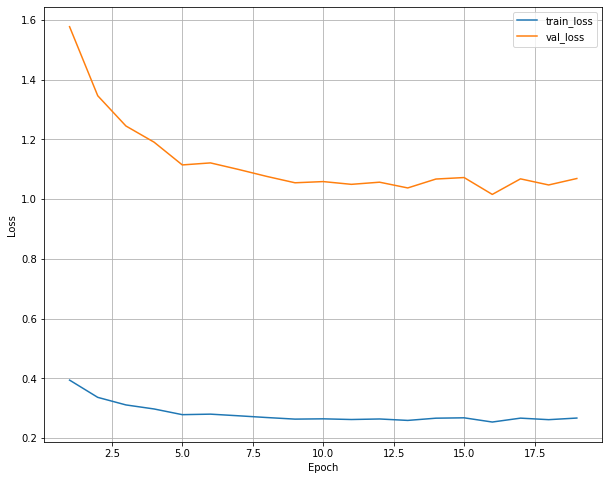

In [180]:
fig, ax = plt.subplots(figsize = (10, 8))
plt.plot(history_epochs, history_loss, label = 'train_loss')
plt.plot(history_epochs, history_loss_val, label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid();

In [181]:
dataset_test = SurnamesDataset(list(X_test), list(y_test), vocab)
test = DataLoader(dataset_test, batch_size = len(dataset_test), shuffle = True)

correct, total = 0, 0

model.eval()
with torch.no_grad():
  for X_tst, y_tst in test:
    out = model(X_tst)
    _, predicted = torch.max(out, dim = 1)
    total += y_tst.shape[0]
    correct += int((predicted == y_tst).sum())

print(f'Accuracy = {correct/total}')

Accuracy = 0.6775956284153005


In [224]:
X_classmates = ['Semenov', 'Zaraev', 'Ragimov']
y_fictit = [0, 0, 0]

classmats = SurnamesDataset(list(X_classmates), list(y_fictit), vocab)

with torch.no_grad():
  for idx, (x, y) in enumerate(classmats):
    out = model(x)
    _, ind = torch.sort(out)
    print(f'Наиболее вероятные нациаональности для фамилии {X_classmates[idx]}:')
    for id, v in enumerate(ind[-3:]):
      ans = list(set(df[df['nationality_label'] == v.item()]['nationality']))[0]
      print(f'{abs(id - 3)}) {ans}')

Наиболее вероятные нациаональности для фамилии Semenov:
3) Russian
2) English
1) Dutch
Наиболее вероятные нациаональности для фамилии Zaraev:
3) Italian
2) Spanish
1) Russian
Наиболее вероятные нациаональности для фамилии Ragimov:
3) Czech
2) Italian
1) Russian


In [205]:
ind = list(ind[-3:])
ind[0].item()

14

In [210]:
list(set(df[df['nationality_label'] == ind[0].item()]['nationality']))[0]

'Russian'

## Классификация обзоров ресторанов

Датасет: https://disk.yandex.ru/d/nY1o70JtAuYa8g

In [7]:
df = pd.read_csv('/content/drive/MyDrive/datasets/raw_train.csv', header = None)
df.columns = ['Label', 'text']
df1 = df[df['Label'] == 1].sample(int(df.shape[0]*0.1/2))
df2 = df[df['Label'] == 2].sample(int(df.shape[0]*0.1/2))
dt = pd.concat([df1, df2], axis = 0)
dt.index = [i for i in range(len(dt))]
dt.shape

(56000, 2)

In [8]:
dt['text'] = dt['text'].apply(preprocess_text)
dt.loc[dt['Label'] == 1, 'Label'] = 0
dt.loc[dt['Label'] == 2, 'Label'] = 1
dt.head()

,Label,text
0,0,just had the rudest worker at the pharmacy. th...
1,0,i shouldn t have signed up for a gym membershi...
2,0,bar far the lowest rated home depot i have eve...
3,0,"ick, ick, ick is all i really need to say. we ..."
4,0,service from waitress lastnight was horrible! ...


In [9]:
X_train, X_test, y_train, y_test = train_test_split(dt['text'], dt['Label'], test_size = 0.2)
X_train.shape, y_train.shape

((44800,), (44800,))

In [10]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [16]:
from nltk.stem import WordNetLemmatizer
lemat = WordNetLemmatizer()

In [17]:
class Vocab:
  def __init__(self, data):
    tokens = []
    for txt in data:
      for sent in sent_tokenize(txt):
        for word in word_tokenize(sent):
          tokens.append(lemat.lemmatize(word,  pos = 'v'))
    
    tokens = set(tokens)
    #print(tokens)
    self.idx_to_token = {idx: token for idx, token in enumerate(tokens)}
    self.token_to_idx = {token: idx for idx, token in self.idx_to_token.items()}
    self.vocab_len = len(self.idx_to_token)

In [18]:
vocab = Vocab(dt['text'])
vocab.vocab_len

66443

In [19]:
class ReviewDataset(Dataset):
  def __init__(self, X, y, vocab: Vocab):
    self.X = X
    self.y = y
    self.vocab = vocab

  def vectorize(self, review):
    '''Генерирует представление отзыва review в виде bag of words (см. 1.2.1)'''
    words_ans = torch.zeros(self.vocab.vocab_len)

    for sent in sent_tokenize(review):
      for word in word_tokenize(sent):
        words_ans[self.vocab.token_to_idx[lemat.lemmatize(word,  pos = 'v')]] += 1

    return words_ans   

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.vectorize(self.X[idx]), self.y[idx]

In [20]:
class ModelReviewNat(nn.Module):
  def __init__(self, input_size, hidden_size, n_classes):
    super().__init__()
    self.layer1 = nn.Sequential(nn.Linear(input_size, hidden_size),
                                nn.ReLU(),
                                nn.Dropout())
    self.layer2 = nn.Sequential(nn.Linear(hidden_size, int(hidden_size)),
                                nn.ReLU(),
                                nn.Dropout())
    self.layer3 = nn.Sequential(nn.Linear(int(hidden_size), int(hidden_size/2)),
                                nn.ReLU(),
                                nn.Dropout())
    self.layer4 = nn.Sequential(nn.Linear(int(hidden_size/2), int(hidden_size/2)),
                                nn.ReLU())
    self.layer5 = nn.Linear(int(hidden_size/2), n_classes)

  def forward(self, X):
    out = self.layer1(X)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    return out

In [21]:
dataset_train = ReviewDataset(list(X_train), list(y_train), vocab)

train_size = int(np.floor(0.8 * len(dataset_train)))
val_size = len(dataset_train) - train_size

train_dataset, test_dataset = random_split(dataset_train, [train_size, val_size])

train_data = DataLoader(train_dataset, batch_size = 32, shuffle = True)
validation = DataLoader(test_dataset, batch_size = 32, shuffle = True)

input_size = dataset_train[0][0].shape[0]
hidden_size = 512
n_classes = dt['Label'].nunique()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ModelReviewNat(input_size, hidden_size, n_classes).to(device = device)
criteriation = nn.CrossEntropyLoss()
optimizare = optim.Adam(model.parameters(), lr = 0.001)

early_stop = EarlyStopping(patience = 3, verbose = False, delta = 0.0)

n_epochs = 500

history_loss = list()
history_loss_val = list()
history_epochs = list()

for epoch in range(1, n_epochs + 1):
  loss_train = 0
  loss_val = 0

  model.train()
  for name, label in train_data:
    name, label = name.to(device = device), label.to(device = device)
    out = model(name)

    loss = criteriation(out, label)
    loss_train += loss

    loss.backward()
    optimizare.step()
    optimizare.zero_grad()

  model.eval()
  with torch.no_grad():
    for X, y in validation:
      X, y = X.to(device = device), y.to(device = device)
      out = model(X)
      loss = criteriation(out, y)
      loss_val += loss

  history_loss.append(loss_val/len(train_data))
  history_loss_val.append(loss_val/len(validation))
  history_epochs.append(epoch)

  if epoch % 2 == 0:
    print(f'Epoch: [{epoch}/{n_epochs}]: Loss_Train = {history_loss[-1]}; Loss_Validation = {history_loss_val[-1]}')

  early_stop(history_loss_val[-1], model)
  
  if early_stop.early_stop:
      print(f"Early stopping on epoch: [{epoch}/{n_epochs}]")
      break

Epoch: [2/500]: Loss_Train = 0.0586184561252594; Loss_Validation = 0.2344738245010376
EarlyStopping counter: 1 out of 3
EarlyStopping counter: 2 out of 3
Epoch: [4/500]: Loss_Train = 0.057844046503305435; Loss_Validation = 0.23137618601322174
EarlyStopping counter: 3 out of 3
Early stopping on epoch: [4/500]


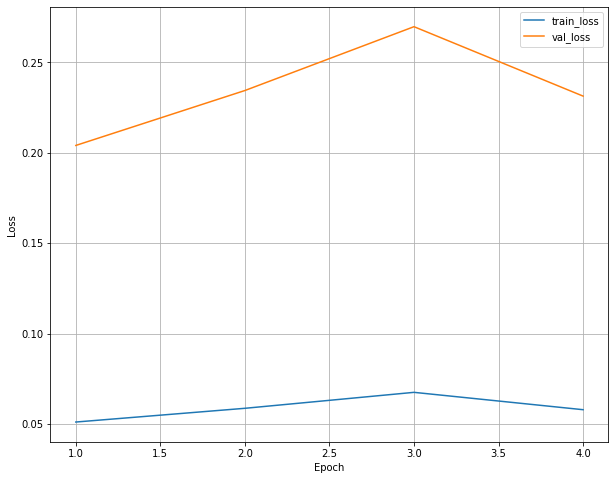

In [22]:
fig, ax = plt.subplots(figsize = (10, 8))
plt.plot(history_epochs, history_loss, label = 'train_loss')
plt.plot(history_epochs, history_loss_val, label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid();

In [24]:
dataset_test = ReviewDataset(list(X_test), list(y_test), vocab)
test = DataLoader(dataset_test, batch_size = len(dataset_test), shuffle = True)

correct, total = 0, 0

model.eval()
with torch.no_grad():
  for X_tst, y_tst in test:
    X_tst, y_tst = X_tst.to(device = device), y_tst.to(device = device)

    out = model(X_tst)
    _, predicted = torch.max(out, dim = 1)
    total += y_tst.shape[0]
    correct += int((predicted == y_tst).sum())

print(f'Accuracy = {correct/total}')

Accuracy = 0.9182142857142858


In [29]:
dt[dt['Label'] == 1]['text'].iloc[0]

'outstanding service noutstanding authentic food noutstanding overall.'

In [51]:
negative = 'The food in the dining room is very awful. Afterwards I want to puke, as if the dogs were being fed'
negative = preprocess_text(negative)
positive = 'Everything was great. Nice movie, delicious food.'
positive = preprocess_text(positive)

X_classmates = [negative, positive]
y_fictit = [0, 0]

reviews = ReviewDataset(X_classmates, y_fictit, vocab)
rev = DataLoader(reviews, batch_size = 1, shuffle = True)

with torch.no_grad():
  for x, y in rev:
    x, y = x.to(device = device), x.to(device = device)
    out = model(x)
    _, predicted = torch.max(out, dim = 1)
    
    print(predicted.item())

# 0 - негативный отзыв
# 1 - позитивный отзыв

0
1
